<a href="https://colab.research.google.com/github/thijsgelton/P10-G7_GANs/blob/main/P10_G7_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision
Generative adversarial networks
```

```
Group number: 7
Student 1 name/number: Marit Hagens, s4808061
Student 2 name/number: Joost Verhaert, s1047220
Student 3 name/number: Thijs Gelton, s4480783
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

#1. Install MXnet GPU and import libraries

In [2]:
!pip install mxnet-cu101

     |████████████████████████████████| 356.7MB 48kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [47]:
from mxnet import nd, gluon
from mxnet import autograd as ag
from mxnet.gluon import nn, utils

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import math
import os
import tarfile
from tqdm.notebook import tqdm
import seaborn as sns
from zipfile import ZipFile

%matplotlib inline

# Feel free to import other modules/packages

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## 1.1 Set device context to gpu.

In [4]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)

gpu = gpu_device()

if gpu:
    print('Using GPU for model_ctx')
    ctx = gpu
else:
    print('Using CPU for model_ctx')
    ctx = mx.cpu()

Using GPU for model_ctx


### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

### Set hyperparameters

In [5]:
epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100
lr = 0.0002
beta1 = 0.5

### Download and preprocess the LWF Face Dataset

In [6]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with ZipFile(data_file) as zipFile:
        zipFile.extractall(path=data_path)

Download the pokemon dataset via [this link](https://drive.google.com/drive/folders/1tO48PdTgdGeR4yYcm44OQkmme-MgT-jL?usp=sharing) and save it to your personal Google Drive. 

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
        
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

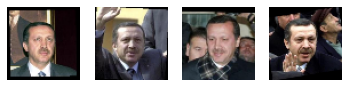

In [8]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

## Define the network


In [11]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))

In [12]:
# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

## Setup Loss Function and Optimizer

In [13]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

INFO:root:
binary training acc at epoch 0: facc=0.848241
INFO:root:time: 45.465403


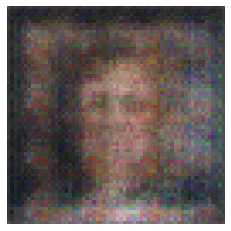

INFO:root:
binary training acc at epoch 1: facc=0.874623
INFO:root:time: 43.887358


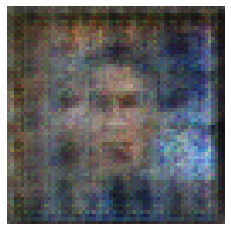

INFO:root:
binary training acc at epoch 2: facc=0.877793
INFO:root:time: 43.820330


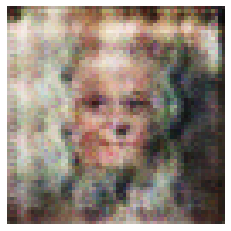

INFO:root:
binary training acc at epoch 3: facc=0.885152
INFO:root:time: 43.771483


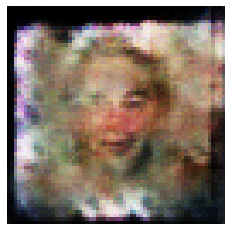

INFO:root:
binary training acc at epoch 4: facc=0.888813
INFO:root:time: 43.813497


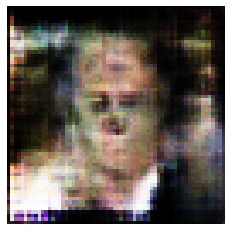

INFO:root:
binary training acc at epoch 5: facc=0.880435
INFO:root:time: 43.775644


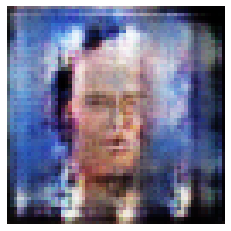

INFO:root:
binary training acc at epoch 6: facc=0.900551
INFO:root:time: 43.719914


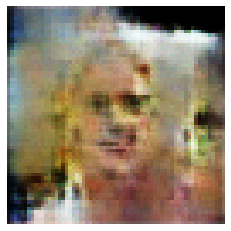

INFO:root:
binary training acc at epoch 7: facc=0.893078
INFO:root:time: 43.785319


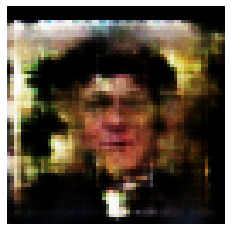

INFO:root:
binary training acc at epoch 8: facc=0.897418
INFO:root:time: 43.733825


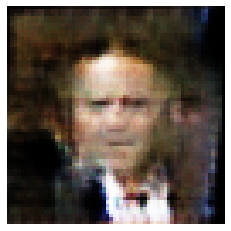

INFO:root:
binary training acc at epoch 9: facc=0.901683
INFO:root:time: 43.785179


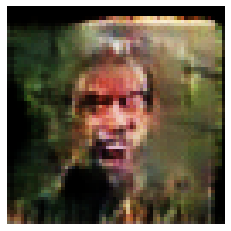

In [14]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with ag.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with ag.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        # if iter % 10 == 0:
        #     name, acc = metric.get()
        #     logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
        #     logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
        #              %(nd.mean(errD).asscalar(),
        #                nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

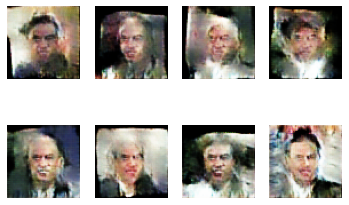

In [15]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

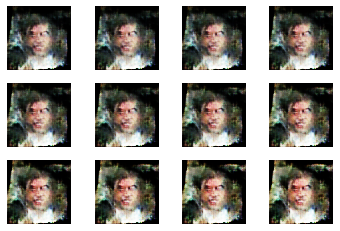

In [16]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

## Define the network


In [43]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))

In [44]:
# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

## Setup Loss Function and Optimizer

In [45]:
# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'rmsprop', {'learning_rate': 0.00005})
trainerD = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.00005, 'clip_gradient': 0.01})

D loss: -7487.27392578125
G loss: 3628.30322265625
Acc: ('facc', 0.5)


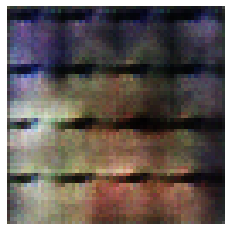

D loss: -7736.8115234375
G loss: 3748.293212890625
Acc: ('facc', 0.5)


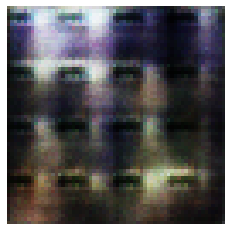

D loss: -7987.302734375
G loss: 3869.646484375
Acc: ('facc', 0.5)


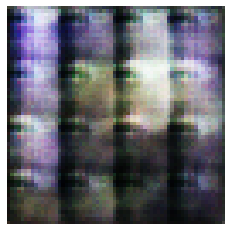

D loss: -8241.9619140625
G loss: 3991.826904296875
Acc: ('facc', 0.5)


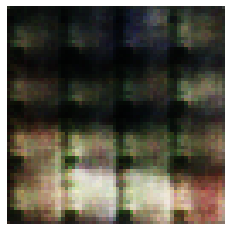

D loss: -8495.431640625
G loss: 4114.64892578125
Acc: ('facc', 0.5)


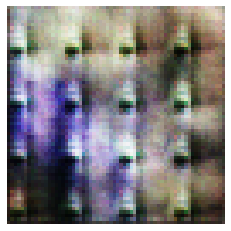

D loss: -8760.5234375
G loss: 4241.71875
Acc: ('facc', 0.5)


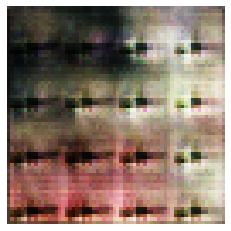

D loss: -9026.697265625
G loss: 4369.26318359375
Acc: ('facc', 0.5)


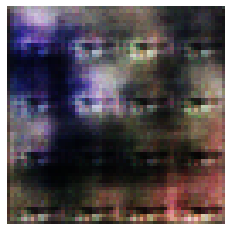

D loss: -9276.8349609375
G loss: 4493.27197265625
Acc: ('facc', 0.5)


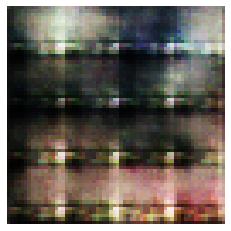

D loss: -9556.0166015625
G loss: 4627.02685546875
Acc: ('facc', 0.5)


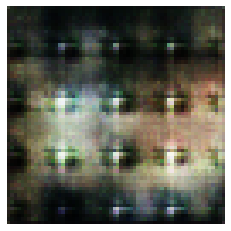

D loss: -9837.333984375
G loss: 4760.23046875
Acc: ('facc', 0.5)


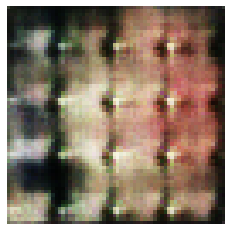

D loss: -10107.6298828125
G loss: 4891.95458984375
Acc: ('facc', 0.5)


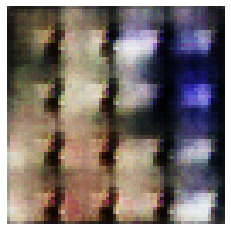

D loss: -10390.1083984375
G loss: 5027.0947265625
Acc: ('facc', 0.5)


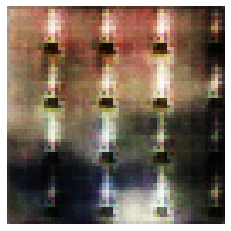

D loss: -10678.2275390625
G loss: 5165.8876953125
Acc: ('facc', 0.5)


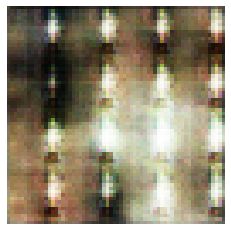

D loss: -10966.4228515625
G loss: 5304.11376953125
Acc: ('facc', 0.5)


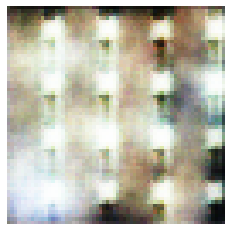

D loss: -11245.103515625
G loss: 5440.138671875
Acc: ('facc', 0.5)


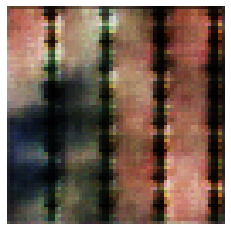

D loss: -11556.6162109375
G loss: 5587.20654296875
Acc: ('facc', 0.5)


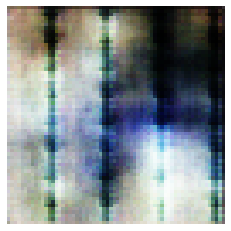

D loss: -11853.9130859375
G loss: 5729.54443359375
Acc: ('facc', 0.5)


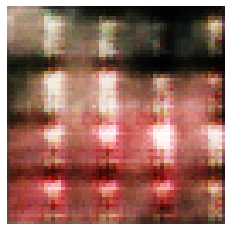

D loss: -12145.478515625
G loss: 5871.64013671875
Acc: ('facc', 0.5)


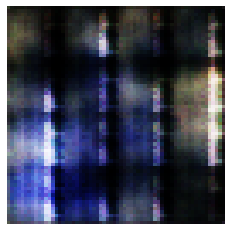

D loss: -12458.4521484375
G loss: 6021.23486328125
Acc: ('facc', 0.5)


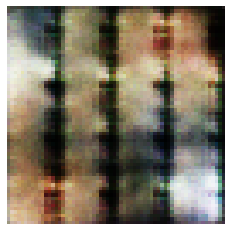

D loss: -12761.4501953125
G loss: 6167.62548828125
Acc: ('facc', 0.5)


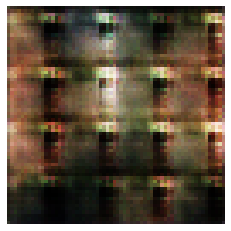

In [55]:
from datetime import datetime
import time
import logging
ncritic = 5

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = -nd.ones((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(20):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    d_loss_epoch = []
    g_loss_epoch = []

    for i, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with ag.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            metric.update([real_label,], [output,])
            d_loss_real = output.mean()

            # train with fake image
            fake = netG(latent_z).detach()
            output = netD(fake).reshape((-1, 1))
            metric.update([fake_label,], [output,])
            d_loss_fake = output.mean()

            d_loss = d_loss_fake - d_loss_real
            d_loss.backward()
            d_loss_epoch.append(d_loss.detach().asnumpy()[0])

        trainerD.step(batch.data[0].shape[0])
        if i % ncritic == 0:
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with ag.record():
                fake = netG(latent_z)
                output = netD(fake).reshape((-1, 1))
                g_loss = -output.mean()
                g_loss.backward()
                g_loss_epoch.append(g_loss.detach().asnumpy()[0])

            trainerG.step(batch.data[0].shape[0])

        iter = iter + 1
        btic = time.time()

    acc = metric.get()
    metric.reset()
    print(f"D loss: {np.array(d_loss_epoch).mean()}\nG loss: {np.array(g_loss_epoch).mean()}\nAcc: {acc}")

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

In [ ]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

In [ ]:
from mxnet.gluon.data.vision import datasets
batch_size = 100

mnist = mx.test_utils.get_mnist()
mnist_train_data = mx.io.NDArrayIter(mnist['train_data'].reshape(-1, 784), mnist['train_label'], batch_size, shuffle=True)
mnist_val_data = mx.io.NDArrayIter(mnist['test_data'].reshape(-1, 784), mnist['test_label'], batch_size)

mnist_fashion = datasets.FashionMNIST(train=True)
mnist_fashion_train_data = mx.io.NDArrayIter(mnist['train_data'].reshape(-1, 784), mnist['train_label'], batch_size, shuffle=True)
mnist_fashiont_val_data = mx.io.NDArrayIter(mnist['test_data'].reshape(-1, 784), mnist['test_label'], batch_size)